## 1.加载数据与神经网络部分

In [1]:
import numpy as np
import urllib.request
import gzip
import os
import pickle
import matplotlib.pyplot as plt


def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    # 用dataset字典保存由4个文件读取得到的np数组
    dataset = {}
    # 若不存在pkl文件，下载文件导入numpy数组，并生成pkl文件
    if not os.path.exists('mnist.pkl'):
        # MNIST数据集的4个文件
        key_file = {
            'train_img': 'train-images-idx3-ubyte.gz', 
            'train_label': 'train-labels-idx1-ubyte.gz',
            'test_img': 't10k-images-idx3-ubyte.gz', 
            'test_label': 't10k-labels-idx1-ubyte.gz'
        }
        # 下载文件并导入numpy数组
        for _ in key_file.keys():
            print('Downloading ' + key_file[_] + '...')
            urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/' 
                                       + key_file[_], key_file[_])  # 下载文件
            print('Download finished!')
            with gzip.open(key_file[_], 'rb') as f:
                dataset[_] = np.frombuffer(f.read(), np.uint8,
                                           offset=16 if _ == 'train_img' or _ == 'test_img' else 8)
                if _ == 'train_img' or _ == 'test_img':
                    dataset[_] = dataset[_].reshape(-1, 1, 28, 28)
        # 生成mnist.pkl
        print('Creating pickle file ...')
        with open('mnist.pkl', 'wb') as f:
            pickle.dump(dataset, f, -1)
        print('Create finished!')
    # 若存在pkl文件，把pkl文件内容导入numpy数组
    else:
        with open('mnist.pkl', 'rb') as f:
            dataset = pickle.load(f)
    # 标准化处理
    if normalize:
        for _ in ('train_img', 'test_img'):
            dataset[_] = dataset[_].astype(np.float32) / 255.0
    # one_hot_label处理
    if one_hot_label:
        for _ in ('train_label', 'test_label'):
            t = np.zeros((dataset[_].size, 10))
            for idx, row in enumerate(t):
                row[dataset[_][idx]] = 1
            dataset[_] = t
    # 展平处理
    if flatten:
        for _ in ('train_img', 'test_img'):
            dataset[_] = dataset[_].reshape(-1, 784)
    # 返回np数组
    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


def relu(x):
    return np.maximum(x, 0, x)


def relu_grad(x):
    return (x > 0).astype(np.int32)


def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    x = x - np.max(x)  # 防止溢出
    return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
    y_batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(y_batch_size), t] + 1e-7)) / y_batch_size


def numerical_gradient(f, x):
    h = 1e-4  # 0.0001
    x_grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        x[idx] = tmp_val - h
        fxh2 = f(x)  # f(x-h)
        x_grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val  # 还原值
        it.iternext()
    return x_grad


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01, reg=1e-4):
        # 初始化权重
        self.params = {
            'W1': weight_init_std * np.random.randn(input_size, hidden_size),
            'b1': np.zeros(hidden_size),
            'W2': weight_init_std * np.random.randn(hidden_size, output_size),
            'b2': np.zeros(output_size)
        }
        self.reg = reg

    def predict(self, x):
        w1, w2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, w1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, w2) + b2
        y = softmax(a2)
        return y

    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t) + 0.5 * self.reg * (np.sum(self.params['W1']**2) + np.sum(self.params['W2']**2))

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        def loss_w(): return self.loss(x, t)
        grads = {
            'W1': numerical_gradient(loss_w, self.params['W1']),
            'b1': numerical_gradient(loss_w, self.params['b1']),
            'W2': numerical_gradient(loss_w, self.params['W2']),
            'b2': numerical_gradient(loss_w, self.params['b2'])
        }
        return grads

    def gradient(self, x, t):
        w1, w2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        batch_num = x.shape[0]
        # forward
        a1 = np.dot(x, w1) + b1
        z1 = sigmoid(a1)
#         z1 = relu(a1)
        a2 = np.dot(z1, w2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy) + self.reg*w2
        grads['b2'] = np.sum(dy, axis=0)
        da1 = np.dot(dy, w2.T)
        dz1 = sigmoid_grad(a1) * da1
#         dz1 = relu_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1) + self.reg*w1
        grads['b1'] = np.sum(dz1, axis=0)
        return grads

## 2.训练部分

In [4]:
# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
# 生成网络
if os.path.exists('model.pkl'):
    with open('model.pkl', 'rb') as fp:
        network = pickle.load(fp)
else:
    network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10, reg=1e-3)

iter_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
alpha_list = [1, 0.5, 0.1, 0.05]
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)
for i in range(iter_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 梯度
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        if i%2500 == 0:
            alpha = alpha_list[i//2500]
        network.params[key] -= learning_rate * grad[key]
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    test_loss = network.loss(x_test, t_test)
    test_loss_list.append(test_loss)
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"train_acc:{train_acc}, test_acc:{test_acc}" )
# 保存模型，下次训练时不必从头训练
with open('model.pkl', 'wb') as fp:
    pickle.dump(network, fp, -1)

train_acc:0.10758333333333334, test_acc:0.1083
train_acc:0.7971, test_acc:0.802
train_acc:0.8774166666666666, test_acc:0.8817
train_acc:0.8967333333333334, test_acc:0.8998
train_acc:0.9041333333333333, test_acc:0.907
train_acc:0.9093833333333333, test_acc:0.9124
train_acc:0.9150833333333334, test_acc:0.9151
train_acc:0.9179, test_acc:0.9185
train_acc:0.9198833333333334, test_acc:0.9206
train_acc:0.9222, test_acc:0.9232
train_acc:0.92465, test_acc:0.9251
train_acc:0.9259166666666667, test_acc:0.9267
train_acc:0.92945, test_acc:0.9294
train_acc:0.9306166666666666, test_acc:0.9307
train_acc:0.9315333333333333, test_acc:0.9322
train_acc:0.9329666666666667, test_acc:0.9331
train_acc:0.9338166666666666, test_acc:0.9346


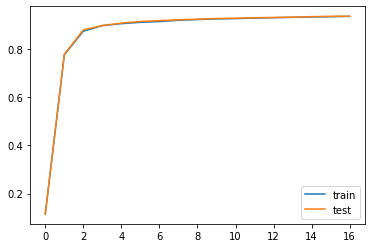

In [24]:
x = [i+1 for i in range(10000)]
plt.plot(train_acc_list, label = 'train')
plt.plot(test_acc_list, label = 'test')
plt.legend()
plt.show()

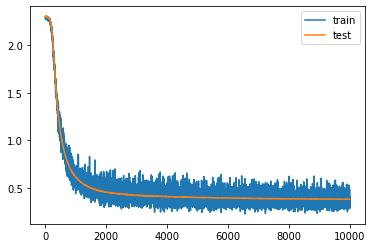

In [62]:
plt.plot(train_loss_list, label = 'train')
plt.plot(test_loss_list, label = 'test')
plt.legend()
plt.show()

## 3.参数可视化

In [25]:
# 参数预处理
W1 = network.params['W1']
W2 = network.params['W2']
W1 = W1.reshape((28, 28, 50))
W1 = (W1-W1.min())/(W1.max()-W1.min())
W2_1 = W2[:49, :]
W2_1.shape
W2_1 = W2_1.reshape((7, 7, 10))

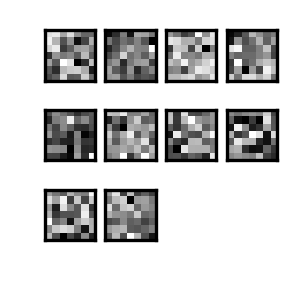

In [49]:
plt.figure(dpi=300,figsize=(1,1))
for i in range(10):
    plt.subplot(3, 4, i+1)
    plt.xticks([]) 
    plt.yticks([])
    plt.imshow(W2_1[:, :, i], cmap='gray')
plt.show()

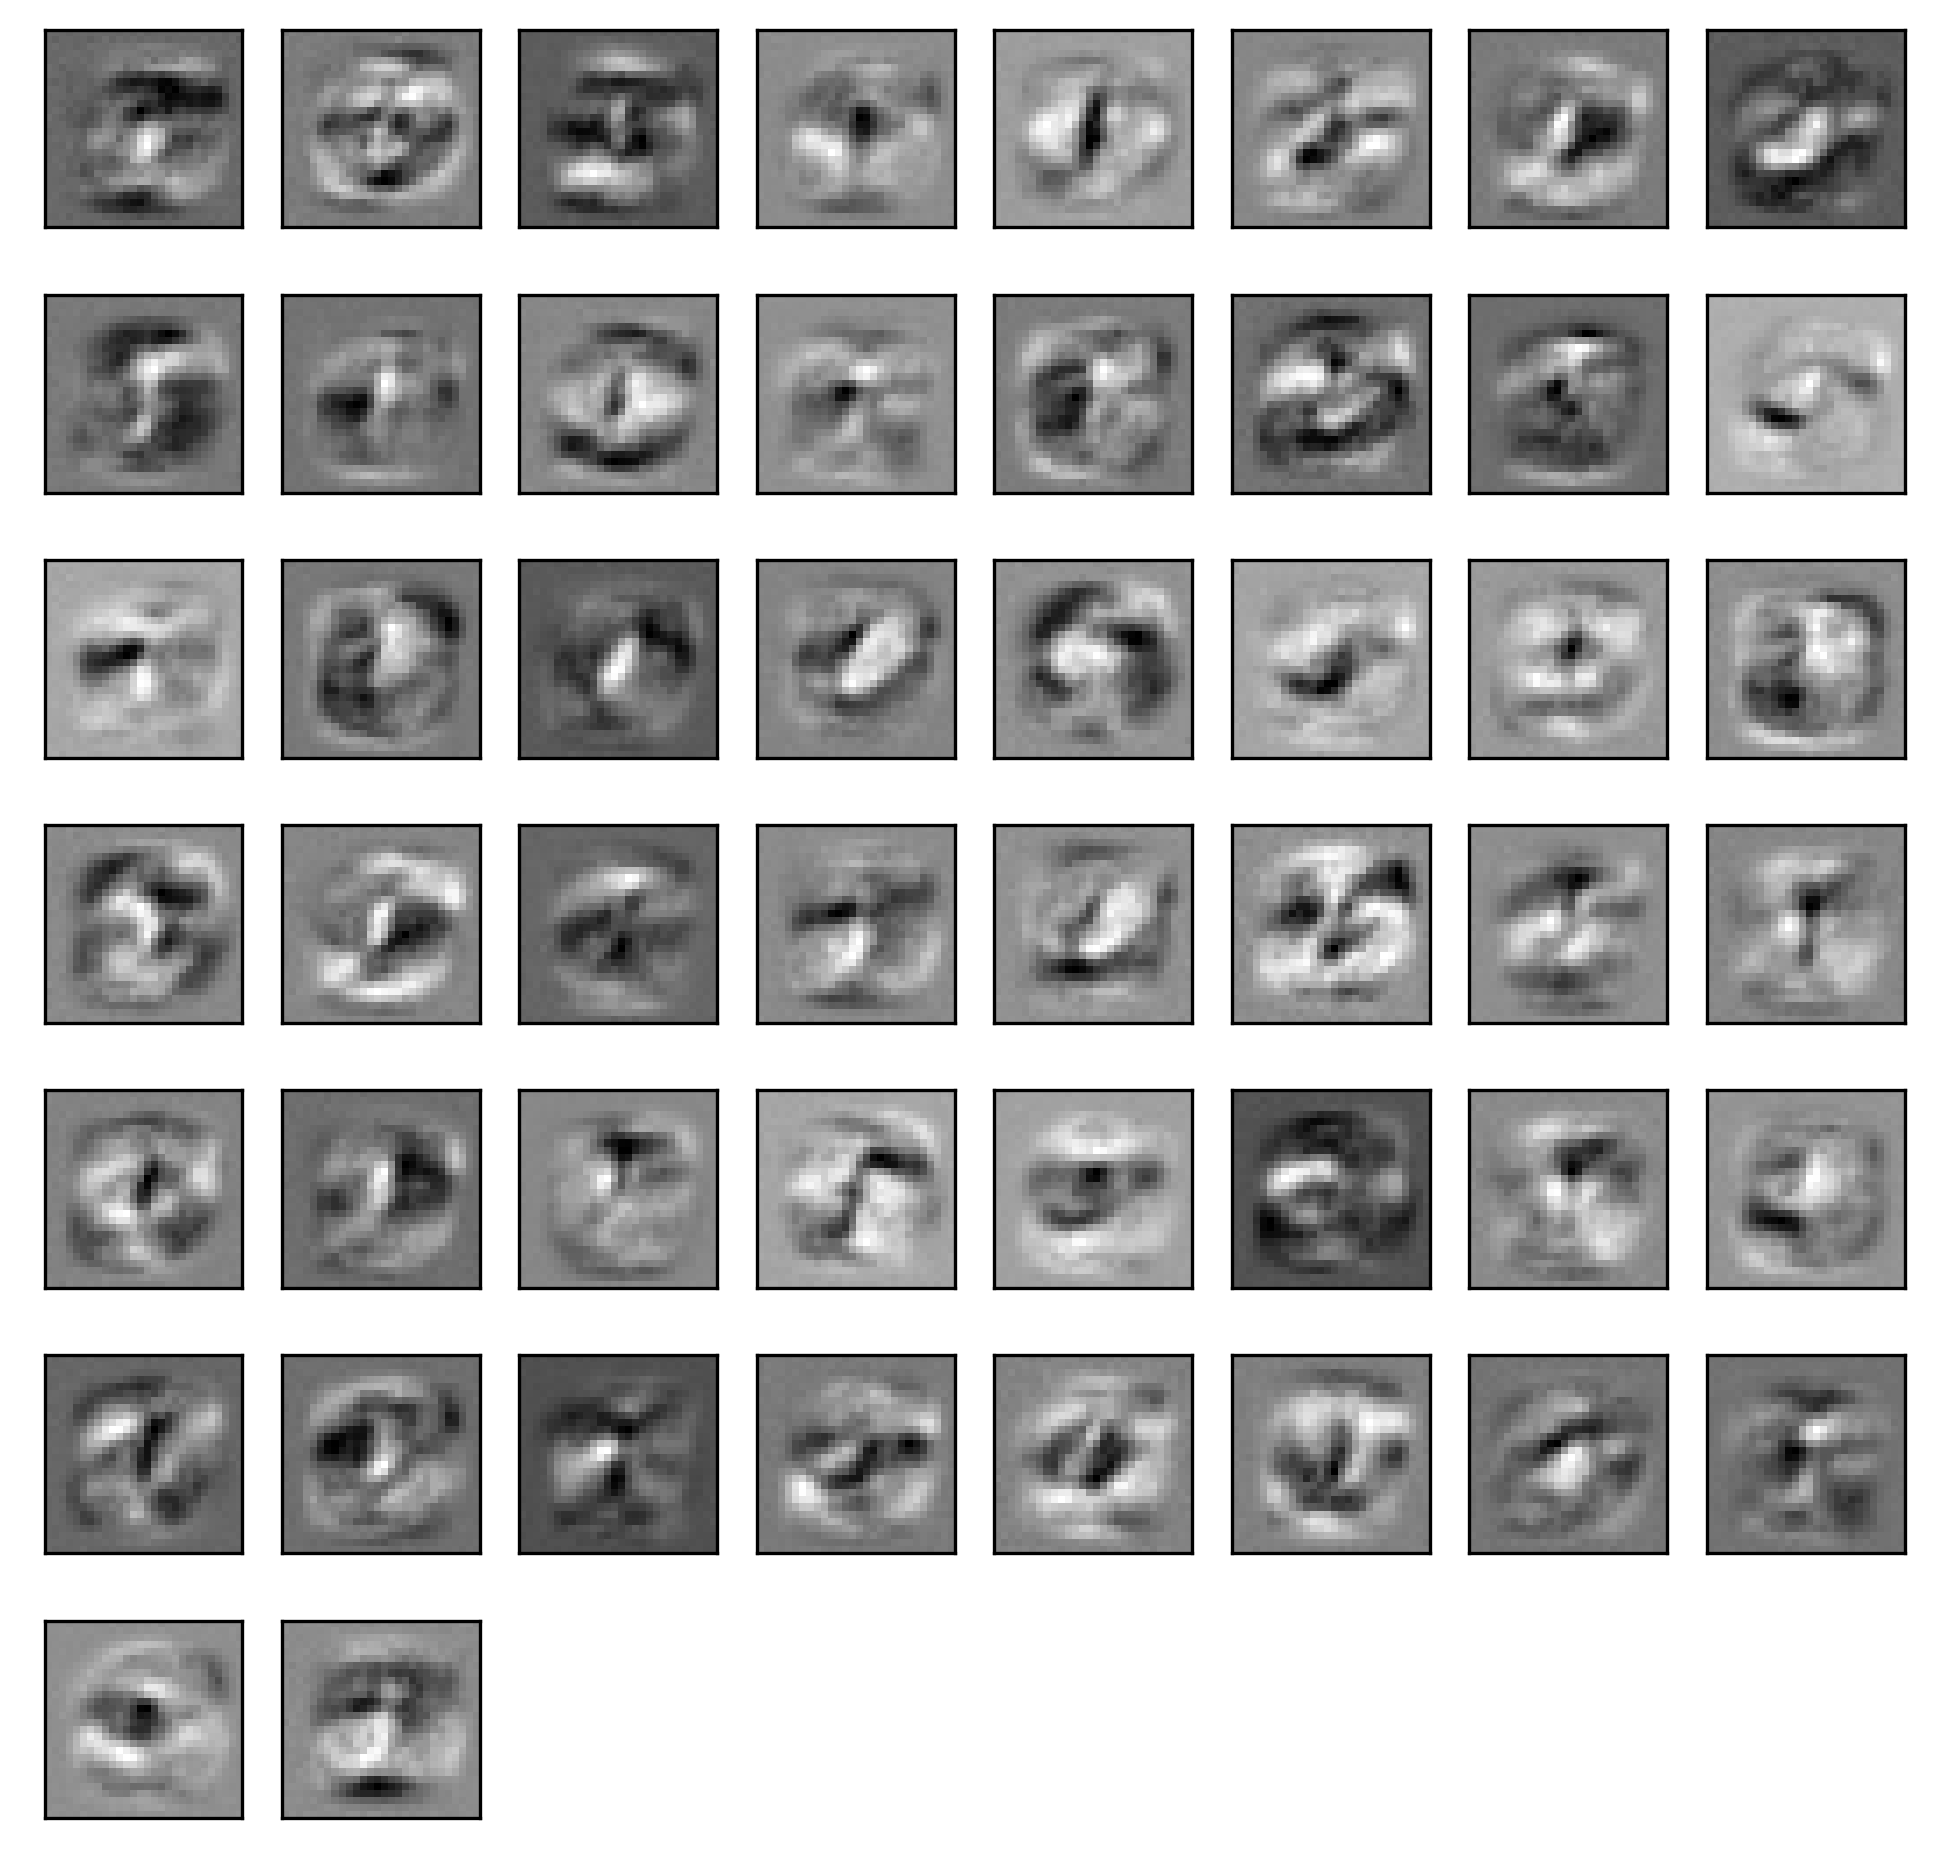

In [28]:
plt.figure(dpi=300,figsize=(8,8))
for i in range(50):
    plt.subplot(7, 8, i+1)
    plt.xticks([]) 
    plt.yticks([])
    plt.imshow(W1[:, :, i], cmap='gray')
plt.show()

## 4. 超参数查找

In [31]:
lr = [0.1, 0.05, 0.01]
hs = [50, 100, 200]
re = [1e-3, 1e-4, 1e-5]
for lr_i in lr:
    for hs_i in hs:
        for re_i in re:
            network = TwoLayerNet(input_size=784, hidden_size=hs_i, output_size=10, reg=re_i)
            iter_num = 10000
            train_size = x_train.shape[0]
            batch_size = 100
            learning_rate = 0.1
            alpha_list = [1, 0.5, 0.1, 0.05]
            train_loss_list = []
            test_loss_list = []
            train_acc_list = []
            test_acc_list = []
            iter_per_epoch = max(train_size / batch_size, 1)
            for i in range(iter_num):
                batch_mask = np.random.choice(train_size, batch_size)
                x_batch = x_train[batch_mask]
                t_batch = t_train[batch_mask]
                grad = network.gradient(x_batch, t_batch)
                for key in ('W1', 'b1', 'W2', 'b2'):
                    if i%2500 == 0:
                        alpha = alpha_list[i//2500]
                    network.params[key] -= lr_i * grad[key]
            test_acc = network.accuracy(x_test, t_test)
            print(f"lr:{lr_i},hs:{hs_i},re_i:{re_i} test_acc:{test_acc}" )

lr:0.1,hs:50,re_i:0.001 test_acc:0.9346
lr:0.1,hs:50,re_i:0.0001 test_acc:0.9445
lr:0.1,hs:50,re_i:1e-05 test_acc:0.945
lr:0.1,hs:100,re_i:0.001 test_acc:0.9337
lr:0.1,hs:100,re_i:0.0001 test_acc:0.9451
lr:0.1,hs:100,re_i:1e-05 test_acc:0.9442
lr:0.1,hs:200,re_i:0.001 test_acc:0.9298
lr:0.1,hs:200,re_i:0.0001 test_acc:0.9398
lr:0.1,hs:200,re_i:1e-05 test_acc:0.9427
lr:0.05,hs:50,re_i:0.001 test_acc:0.9229
lr:0.05,hs:50,re_i:0.0001 test_acc:0.9304
lr:0.05,hs:50,re_i:1e-05 test_acc:0.9309
lr:0.05,hs:100,re_i:0.001 test_acc:0.9241
lr:0.05,hs:100,re_i:0.0001 test_acc:0.9283
lr:0.05,hs:100,re_i:1e-05 test_acc:0.9282
lr:0.05,hs:200,re_i:0.001 test_acc:0.9208
lr:0.05,hs:200,re_i:0.0001 test_acc:0.9249
lr:0.05,hs:200,re_i:1e-05 test_acc:0.9255
lr:0.01,hs:50,re_i:0.001 test_acc:0.8659
lr:0.01,hs:50,re_i:0.0001 test_acc:0.8708
lr:0.01,hs:50,re_i:1e-05 test_acc:0.8674
lr:0.01,hs:100,re_i:0.001 test_acc:0.875
lr:0.01,hs:100,re_i:0.0001 test_acc:0.8756
lr:0.01,hs:100,re_i:1e-05 test_acc:0.8747
lr:0

## 5.测试部分

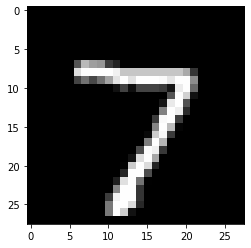

预测结果为：7


In [38]:
# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
x = x_test[0]
t = t_test[0]
plt.imshow(x.reshape((28, 28)), cmap='gray')
plt.show()
# 生成网络
if os.path.exists('model.pkl'):
    with open('model.pkl', 'rb') as fp:
        network = pickle.load(fp)
        pred = network.predict(x)
        print(f"预测结果为：{np.argmax(pred)}")
else:
    print("failed to load model")